In [3]:
#import libraries
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [4]:
#set up
sns.set(style = "whitegrid")
os.makedirs("images", exist_ok = True)

#ensure VADER lexicon is available
try:
    nltk.data.find("sentiment/vader_lexicon.zip")
except LookupError:
    nltk.download("vader_lexicon")

In [5]:
#load the data
df = pd.read_csv("linkedin_reviews_raw.csv")

In [6]:
#clean text
def clean(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[\r\n\t]", " ", text)
    text = re.sub(r"[^A-Za-z0-9 .,!?'’]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["review_clean"] = df["review"].apply(clean)

#VADER sentiment
sia = SentimentIntensityAnalyzer()
scores = df["review_clean"].apply(sia.polarity_scores).apply(pd.Series)  
df = pd.concat([df, scores], axis = 1)

#discrete label (common thresholds)
df["sentiment_vader"] = pd.cut(
    df["compound"],
    bins = [-1.01, -0.05, 0.05, 1.01],
    labels = ["negative", "neutral", "positive"]
)

#save clean file
df.to_csv("linkedin_reviews_clean.csv", index = False)

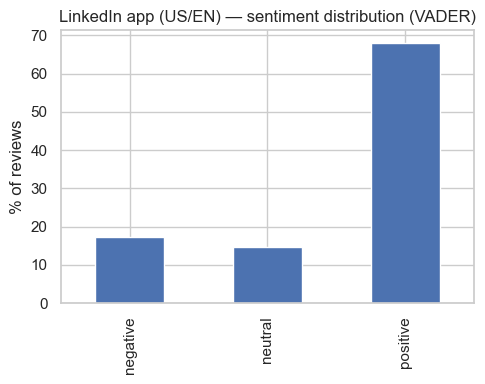

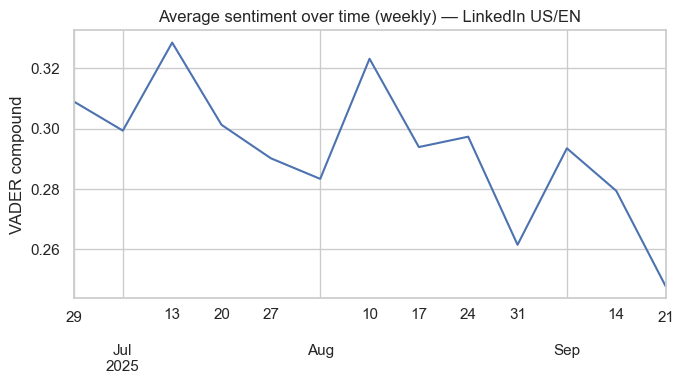

C:\Users\пк\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


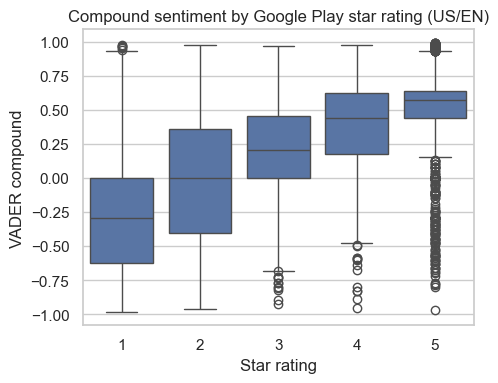

In [7]:
#overall sentiment distribution
plt.figure(figsize = (5, 4))
(df["sentiment_vader"]
    .value_counts(normalize = True)
    .reindex(["negative", "neutral", "positive"])
    .mul(100).round(1)
    .plot(kind = "bar"))
plt.title("LinkedIn app (US/EN) — sentiment distribution (VADER)")
plt.ylabel("% of reviews"); plt.xlabel("")
plt.tight_layout(); plt.savefig("images/sentiment_distribution.png", dpi = 300)
plt.show()

#weekly average sentiment over time
if df["date"].notna().any():
    df["date"] = pd.to_datetime(df["date"], errors = "coerce")
    weekly = df.dropna(subset = ["date"]).groupby(pd.Grouper(key = "date", freq = "W"))["compound"].mean()
    plt.figure(figsize = (7,4))
    weekly.plot()
    plt.title("Average sentiment over time (weekly) — LinkedIn US/EN")
    plt.ylabel("VADER compound"); plt.xlabel("")
    plt.tight_layout(); plt.savefig("images/sentiment_over_time.png", dpi = 300)
    plt.show()

#relationship with star rating
if "rating" in df.columns:
    plt.figure(figsize = (5,4))
    sns.boxplot(data = df, x = "rating", y = "compound")
    plt.title("Compound sentiment by Google Play star rating (US/EN)")
    plt.xlabel("Star rating"); plt.ylabel("VADER compound")
    plt.tight_layout(); plt.savefig("images/sentiment_by_rating.png", dpi = 300)
    plt.show()

In [8]:
#quick summary printout
n = len(df)
pct = (df["sentiment_vader"].value_counts(normalize = True).mul(100).round(1)
       .reindex(["negative", "neutral", "positive"]))
print(f"Processed {n:,} US/EN reviews.")
print("Sentiment split (%):")
print(pct.dropna())

Processed 10,000 US/EN reviews.
Sentiment split (%):
sentiment_vader
negative    17.3
neutral     14.8
positive    67.9
Name: proportion, dtype: float64
